In [2]:
!apt -qq -y install fonts-nanum
%pip install -U --quiet prince
%pip install --quiet statsmodels altair_viewer vega altair duckdb==0.8.1

fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.8 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.8 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Variables

In [3]:
%config InlineBackend.figure_format = 'retina'
%cd /mnt

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import pandas as pd 
import altair as alt
import prince
from pprint import pprint
from pathlib import Path
import duckdb
def sqldf(query):
    return duckdb.query(query).to_df()

pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

/mnt


In [4]:
font_path = Path('/usr/share/fonts/truetype/nanum/NanumGothic.ttf')
fontprop = fm.FontProperties(fname=font_path, size=14, weight="bold")

In [5]:
def series_not_in(series, notin_list):
    s = notin_list[1:]
    _ = series != notin_list[0]
    for __ in s:
        _ = _ & (series!=__)
    return _

# Loading Dataset

In [6]:
data = pd.read_csv("performance_data_new01.csv", sep=",", encoding="CP949")
data = data.loc[(data["model"] != "weighted_Ensemble")]
data.loc[data["score"].apply(pd.isna) & (data["score_type"] != "f1_score") & series_not_in(data["attempt"], [5, 1, 2, 9])] # precision === TP / (TP + FP) ==> (precision == NA) === "every ddata is TN or FN"

,model,attempt,score_type,attack_name,score
325,DNN,0,precision,SQLi,NaN
326,DNN,0,precision,File_Inclusion,NaN
373,DNN,3,precision,SQLi,NaN
374,DNN,3,precision,File_Inclusion,NaN
389,DNN,4,precision,SQLi,NaN
390,DNN,4,precision,File_Inclusion,NaN
421,DNN,6,precision,SQLi,NaN
422,DNN,6,precision,File_Inclusion,NaN
437,DNN,7,precision,SQLi,NaN
438,DNN,7,precision,File_Inclusion,NaN


In [7]:
sqldf("select * from data")

,model,attempt,score_type,attack_name,score
0,file_data_LSTM,0,accuracy,PW_Injection,0.841693
1,file_data_LSTM,0,accuracy,SQLi,1.000000
2,file_data_LSTM,0,accuracy,File_Inclusion,1.000000
3,file_data_LSTM,0,accuracy,XSS,0.841693
4,file_data_LSTM,0,precision,PW_Injection,0.827959
...,...,...,...,...,...
635,non_weighted_Ensemble,9,recall,XSS,0.505310
636,non_weighted_Ensemble,9,f1_score,PW_Injection,0.948298
637,non_weighted_Ensemble,9,f1_score,SQLi,1.000000
638,non_weighted_Ensemble,9,f1_score,File_Inclusion,1.000000


In [8]:
data["model"].unique()

array(['file_data_LSTM', 'payload_LSTM', 'DNN', 'non_weighted_Ensemble'],
      dtype=object)

In [9]:
data["attack_name"].unique()

array(['PW_Injection', 'SQLi', 'File_Inclusion', 'XSS'], dtype=object)

In [10]:
from typing import Literal
def get_info(data, model_name:Literal['file_data_LSTM', 'payload_LSTM', 'DNN', 'non_weighted_Ensemble'], attack_name:Literal['PW_Injection', 'SQLi', 'File_Inclusion', 'XSS']):
    RESULT = data.loc[(data["model"] == model_name) & (data["attack_name"] == attack_name)]
    return [
        {"precision_avg":RESULT.loc[RESULT["score_type"] == "precision"]["score"].sum() / 10, "precision_std": RESULT.loc[RESULT["score_type"] == "precision"]["score"].std() },
        {"accuracy_avg":RESULT.loc[RESULT["score_type"] == "accuracy"]["score"].sum() / 10, "accuracy_std": RESULT.loc[RESULT["score_type"] == "accuracy"]["score"].std() },
        {"recall_avg":RESULT.loc[RESULT["score_type"] == "recall"]["score"].sum() / 10, "recall_std": RESULT.loc[RESULT["score_type"] == "recall"]["score"].std() },
        {"f1_score_avg":RESULT.loc[RESULT["score_type"] == "f1_score"]["score"].sum() / 10, "f1_score_std": RESULT.loc[RESULT["score_type"] == "f1_score"]["score"].std() },
    ]

In [11]:
DNN_XSS = data.loc[(data["model"] == "DNN") & (data["attack_name"] == "XSS")]
[
    {"precision_avg":DNN_XSS.loc[DNN_XSS["score_type"] == "precision"]["score"].sum() / 10, "precision_std": DNN_XSS.loc[DNN_XSS["score_type"] == "precision"]["score"].std() },
    {"accuracy_avg":DNN_XSS.loc[DNN_XSS["score_type"] == "accuracy"]["score"].sum() / 10, "accuracy_std": DNN_XSS.loc[DNN_XSS["score_type"] == "accuracy"]["score"].std() },
    {"recall_avg":DNN_XSS.loc[DNN_XSS["score_type"] == "recall"]["score"].sum() / 10, "recall_std": DNN_XSS.loc[DNN_XSS["score_type"] == "recall"]["score"].std() },
    {"f1_score_avg":DNN_XSS.loc[DNN_XSS["score_type"] == "f1_score"]["score"].sum() / 10, "f1_score_std": DNN_XSS.loc[DNN_XSS["score_type"] == "f1_score"]["score"].std() },
]

[{'precision_avg': 1.0, 'precision_std': 0.0},
 {'accuracy_avg': 0.9135390225590792, 'accuracy_std': 0.001542443515691891},
 {'recall_avg': 0.4929654487218104, 'recall_std': 0.0073671217275911634},
 {'f1_score_avg': 0.6603549560014352, 'f1_score_std': 0.006600592495298415}]

In [12]:
get_info(data, "DNN", "XSS")

[{'precision_avg': 1.0, 'precision_std': 0.0},
 {'accuracy_avg': 0.9135390225590792, 'accuracy_std': 0.001542443515691891},
 {'recall_avg': 0.4929654487218104, 'recall_std': 0.0073671217275911634},
 {'f1_score_avg': 0.6603549560014352, 'f1_score_std': 0.006600592495298415}]

In [13]:
result = {}
for attack_name in data["attack_name"].unique():
    for model_name in data["model"].unique():
        if not result.get(attack_name):
            result[attack_name] = {}
        result[attack_name][model_name] = get_info(data, model_name, attack_name)
pprint(result)

{'File_Inclusion': {'DNN': [{'precision_avg': 0.0, 'precision_std': nan},
                            {'accuracy_avg': 0.9795216474205425,
                             'accuracy_std': 0.0007151851542928706},
                            {'recall_avg': 0.0, 'recall_std': 0.0},
                            {'f1_score_avg': 0.0, 'f1_score_std': nan}],
                    'file_data_LSTM': [{'precision_avg': 0.9,
                                        'precision_std': 0.0},
                                       {'accuracy_avg': 0.99799435129241,
                                        'accuracy_std': 0.006342418102157446},
                                       {'recall_avg': 0.9,
                                        'recall_std': 0.31622776601683794},
                                       {'f1_score_avg': 0.9,
                                        'f1_score_std': 0.0}],
                    'non_weighted_Ensemble': [{'precision_avg': 0.9,
                                             

In [14]:
HLSTM_XSS = data.loc[(data["model"] == "DNN") & (data["attack_name"] == "XSS")]
[
    {"precision_avg":HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "precision"]["score"].sum() / 10, "precision_std": HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "precision"]["score"].std() },
    {"accuracy_avg":HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "accuracy"]["score"].sum() / 10, "accuracy_std": HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "accuracy"]["score"].std() },
    {"recall_avg":HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "recall"]["score"].sum() / 10, "recall_std": HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "recall"]["score"].std() },
    {"f1_score_avg":HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "f1_score"]["score"].sum() / 10, "f1_score_std": HLSTM_XSS.loc[HLSTM_XSS["score_type"] == "f1_score"]["score"].std() },
]

[{'precision_avg': 1.0, 'precision_std': 0.0},
 {'accuracy_avg': 0.9135390225590792, 'accuracy_std': 0.001542443515691891},
 {'recall_avg': 0.4929654487218104, 'recall_std': 0.0073671217275911634},
 {'f1_score_avg': 0.6603549560014352, 'f1_score_std': 0.006600592495298415}]

In [15]:
nans = data.loc[data["score"].apply(pd.isna) & (data["score_type"] != "f1_score") & series_not_in(data["attempt"], [5, 1, 2, 9])]
strs = {
    "file_data_LSTM": "file_data",
    "payload_LSTM": "payload",
    "DNN": "DNN",
    "non_weighted_Ensemble": 'result_confusion_matrix',
}
nan_matrix_list = [[file_name, pd.read_csv(file_name)] for file_name in list("confusion_matrix/"+nans["model"].apply(lambda x: strs[x])+"_attempt_"+nans["attempt"].apply(lambda x: str(x+1).zfill(2))+".csv")]

In [16]:
analysis_no_nan = sqldf("""
                        SELECT model, score_type, attack_name, SUM(score) / COUNT(*) as M, COUNT(*) AS N 
                        FROM data 
                        WHERE NOT data.score IS NULL
                        GROUP BY model, score_type, attack_name""")
analysis = sqldf("""SELECT model, score_type, attack_name, SUM(score) / COUNT(*) as M, COUNT(*) AS N 
                        FROM data 
                        GROUP BY model, score_type, attack_name""")

In [17]:
sqldf("""
      SELECT *
      FROM analysis_no_nan
      WHERE score_type = 'precision'
      """)

,model,score_type,attack_name,M,N
0,file_data_LSTM,precision,PW_Injection,0.825037,10
1,file_data_LSTM,precision,SQLi,1.000000,10
2,file_data_LSTM,precision,File_Inclusion,1.000000,9
3,file_data_LSTM,precision,XSS,1.000000,9
4,payload_LSTM,precision,PW_Injection,0.000000,10
5,payload_LSTM,precision,SQLi,0.054985,10
6,payload_LSTM,precision,File_Inclusion,0.000000,10
7,payload_LSTM,precision,XSS,1.000000,6
8,DNN,precision,PW_Injection,0.831858,10
9,DNN,precision,XSS,1.000000,10


In [18]:
sqldf("""
        SELECT *
        FROM analysis_no_nan
        WHERE 1=1
            -- AND score_type = 'precision'
            -- AND model = 'payload_LSTM'
        ORDER BY score_type, attack_name
      """)

,model,score_type,attack_name,M,N
0,file_data_LSTM,accuracy,File_Inclusion,0.997994,10
1,non_weighted_Ensemble,accuracy,File_Inclusion,0.997994,10
2,DNN,accuracy,File_Inclusion,0.979522,10
3,payload_LSTM,accuracy,File_Inclusion,0.979447,10
4,payload_LSTM,accuracy,PW_Injection,0.094215,10
5,non_weighted_Ensemble,accuracy,PW_Injection,0.911533,10
6,DNN,accuracy,PW_Injection,0.845990,10
7,file_data_LSTM,accuracy,PW_Injection,0.838322,10
8,file_data_LSTM,accuracy,SQLi,1.000000,10
9,non_weighted_Ensemble,accuracy,SQLi,1.000000,10


In [19]:
%config InlineBackend.figure_format = 'svg'

# 성능평가

## score_type - Attack Name

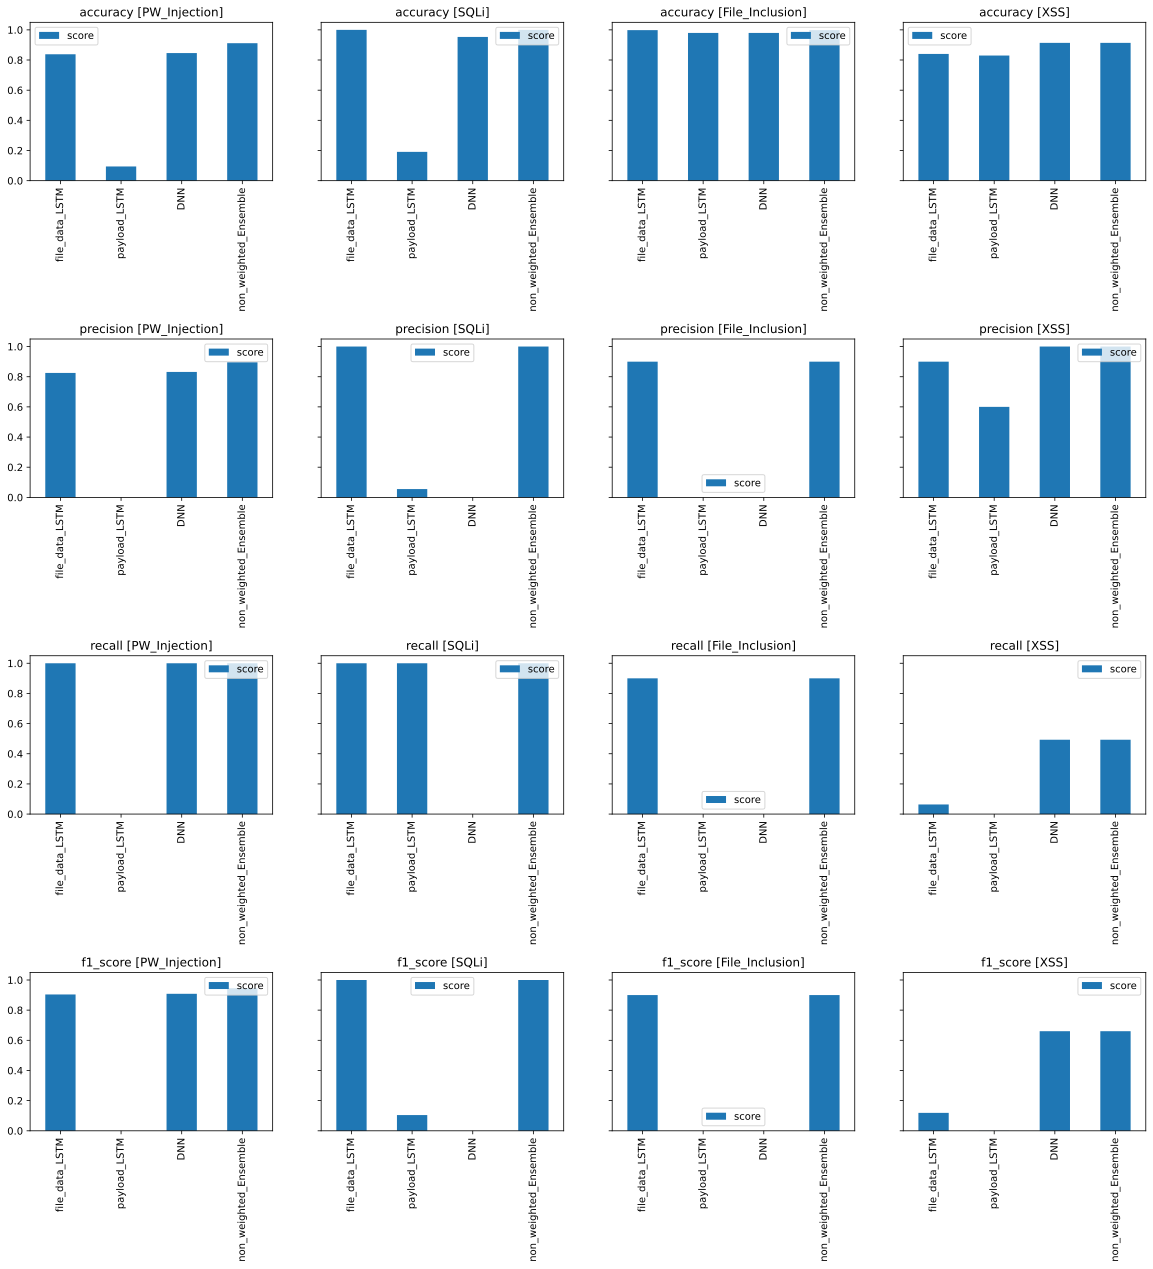

In [20]:
plt.rcParams['figure.figsize'] = [30, 50]
plt.rcParams['figure.dpi'] = 200

fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharey=True)
fig.subplots_adjust(hspace=1)
plots = [
  sqldf(f"""
          SELECT model AS model_name, M as score 
          FROM analysis
          WHERE score_type = '{score_type}'
            AND attack_name = '{attack_name}'
          """).plot(x="model_name", y=["score"], kind='bar', subplots=True, figsize=(7,3), title=[f"{score_type} [{attack_name}]"], ax=axes[iy, ix], xlabel="")
    for iy, score_type in enumerate(sqldf("SELECT DISTINCT score_type FROM analysis")["score_type"])
    for ix, attack_name in enumerate(sqldf("SELECT DISTINCT attack_name FROM analysis")["attack_name"])
]

## Model - Attack Name

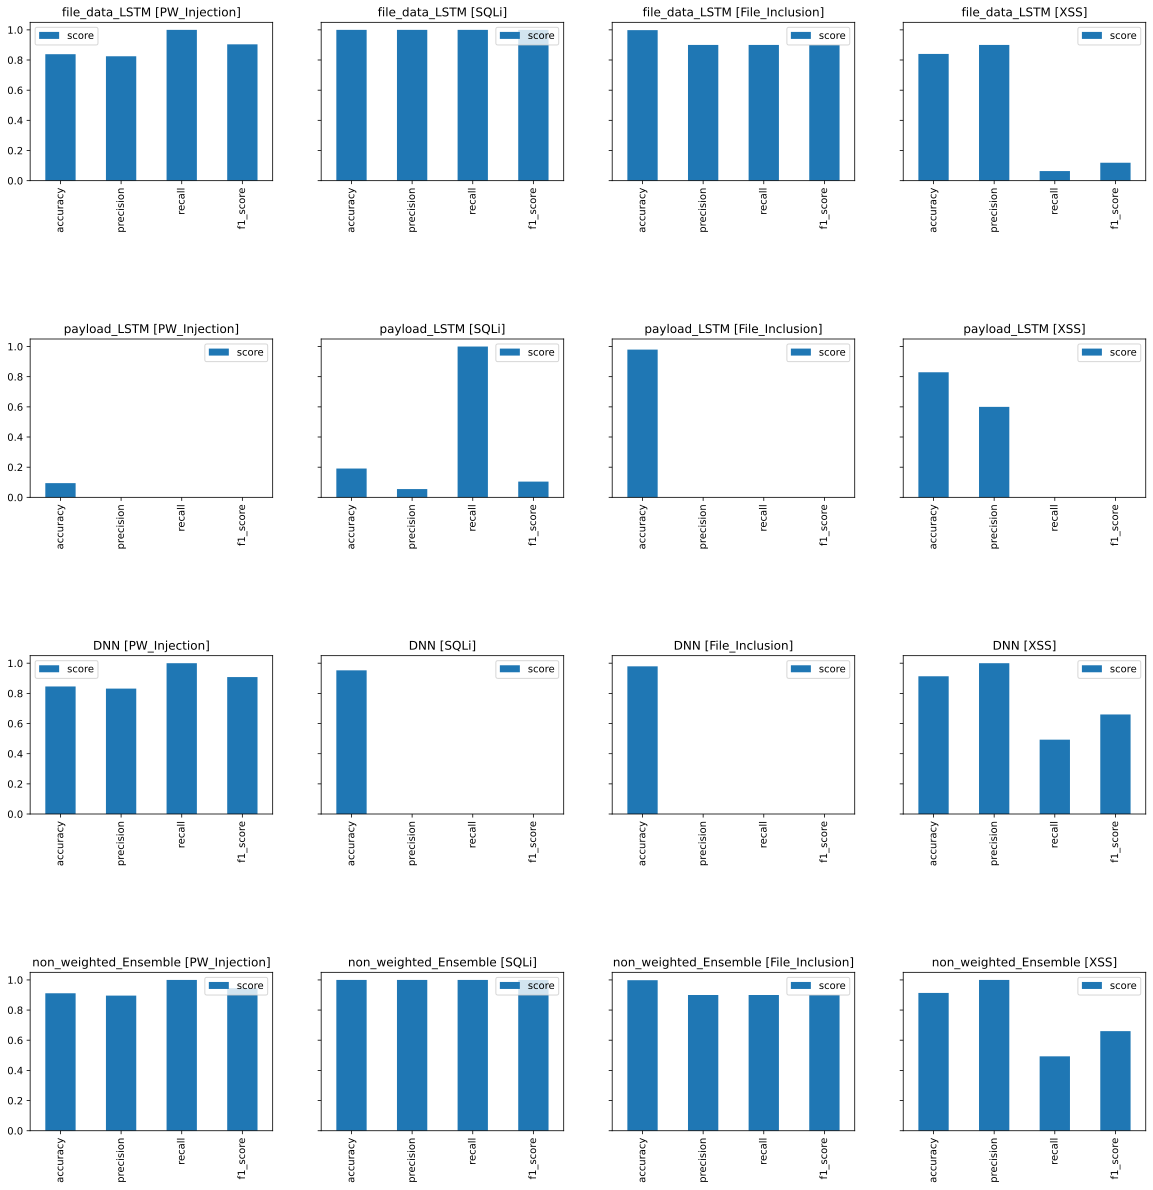

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharey=True)
fig.subplots_adjust(hspace=1)
plots = [
  sqldf(f"""
          SELECT score_type, M as score 
          FROM analysis
          WHERE model = '{model}'
            AND attack_name = '{attack_name}'
          """).plot(x="score_type", y=["score"], kind='bar', subplots=True, figsize=(7,3), title=[f"{model} [{attack_name}]"], ax=axes[iy, ix], xlabel="")
    for iy, model in enumerate(sqldf("SELECT DISTINCT model FROM analysis")["model"])
    for ix, attack_name in enumerate(sqldf("SELECT DISTINCT attack_name FROM analysis")["attack_name"])
]

## Model - Score Type

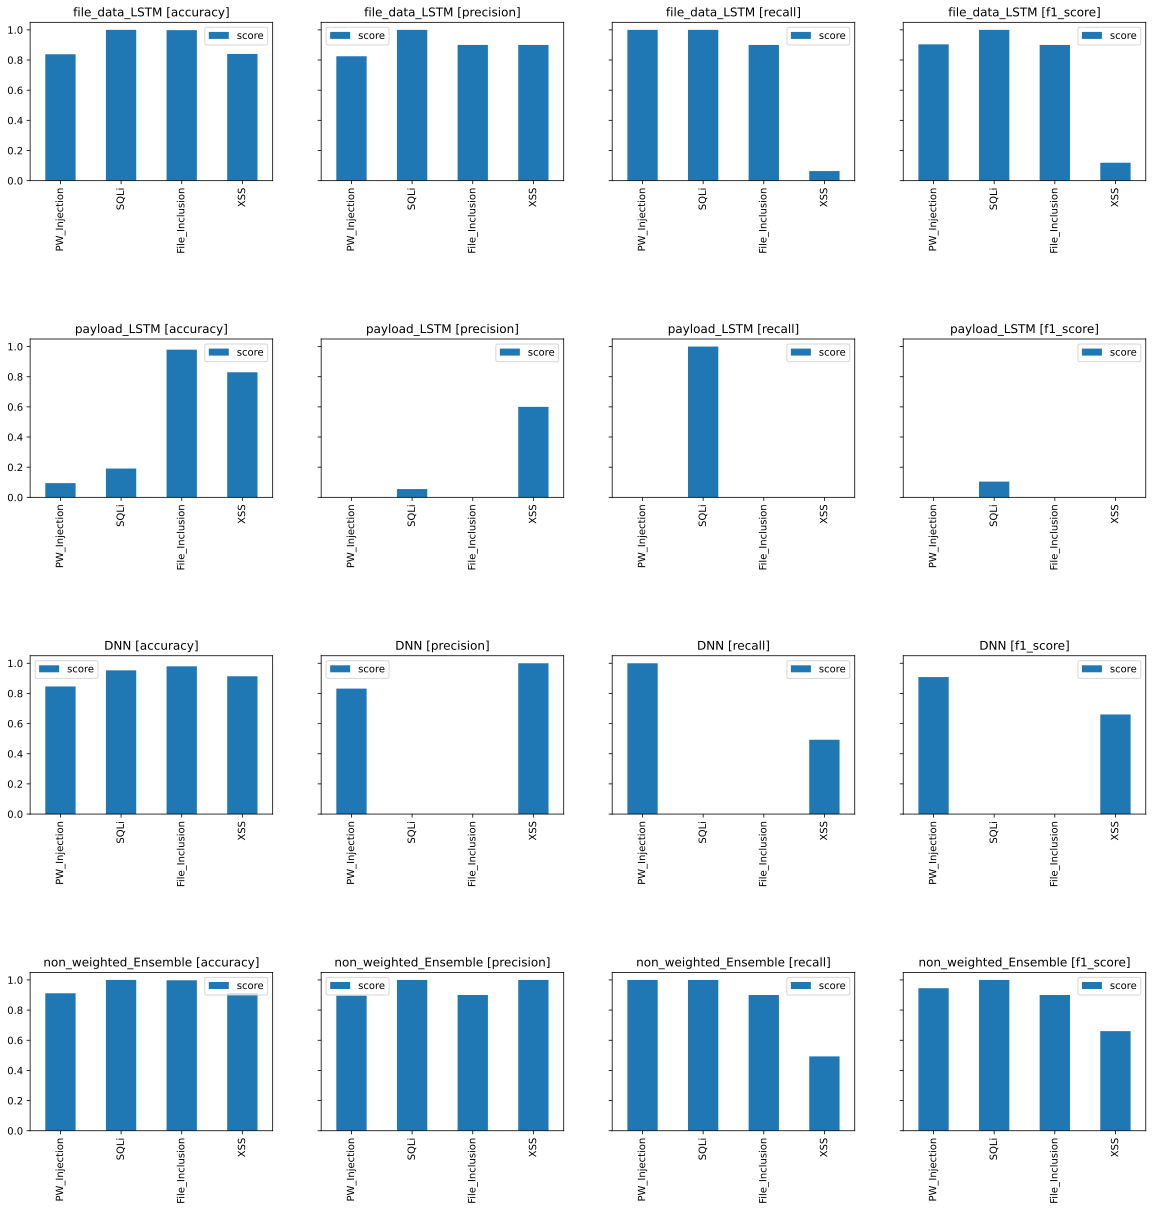

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharey=True)
fig.subplots_adjust(hspace=1)
plots = [
  sqldf(f"""
          SELECT attack_name, M as score 
          FROM analysis
          WHERE model = '{model}'
            AND score_type = '{score_type}'
          """).plot(x="attack_name", y=["score"], kind='bar', subplots=True, figsize=(7,3), title=[f"{model} [{score_type}]"], ax=axes[iy, ix], xlabel="")
    for iy, model in enumerate(sqldf("SELECT DISTINCT model FROM analysis")["model"])
    for ix, score_type in enumerate(sqldf("SELECT DISTINCT score_type FROM analysis")["score_type"])
]

In [23]:
sqldf(f"""
          SELECT model, SUM(M) / COUNT(*) as score 
          FROM analysis
          WHERE attack_name = '{attack_name}'
          GROUP BY model, attack_name
          """)

,model,score
0,file_data_LSTM,0.480688
1,payload_LSTM,0.357470
2,DNN,0.766715
3,non_weighted_Ensemble,0.766715


## Model - Score macro average

In [148]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix


conf_matrix = pd.read_csv("confusion_matrix/DNN_attempt_01.csv", index_col=0)
def get_matrix_vals(cnf_matrix, _dict_=True):
    length = int(cnf_matrix.sum().sum())
    index = ["PW_Attack", "SQLi", "File_Inclusion", "XSS"]
    _FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  # column
    _FP.index = index
    _FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix) # rows
    _FN.index = index
    _TP = pd.Series(np.diag(cnf_matrix), index=index) 
    _TN = pd.Series([length for _ in range(4)], index=index) - (_FP + _FN + _TP) 
    
    if not _dict_: return {
        "FP":_FP, "FN":_FN, "TP":_TP, "TN":_TN, "length": length
    }
    return {"FP":_FP.to_dict(), "FN":_FN.to_dict(), "TP":_TP.to_dict(), "TN":_TN.to_dict(), "length": length}
def micro_f1(TP, FP, FN):
    return TP / (TP + (FP+FN)/2 )
mat = get_matrix_vals(conf_matrix, False)
micro_f1(mat.get("TP"), mat.get("FP"), mat.get("FN"))

PW_Attack         0.908142
SQLi              0.000000
File_Inclusion    0.000000
XSS               0.662345
dtype: float64

In [154]:
import os, pathlib
confusion_matrix_path = pathlib.Path("confusion_matrix")
f1_micros = {}
for csv in os.listdir(confusion_matrix_path):
    filename = csv
    conf_matrix = pd.read_csv(os.path.join(confusion_matrix_path, csv), index_col=0)
    mat = get_matrix_vals(conf_matrix, False)
    model_name, attempt = csv.replace(".csv","").split("_attempt_")
    if f1_micros.get(model_name):
        f1_micros[model_name].append(
            micro_f1(mat.get("TP"), mat.get("FP"), mat.get("FN"))
        )
    else:
        f1_micros[model_name] = [
            micro_f1(mat.get("TP"), mat.get("FP"), mat.get("FN"))
        ]

array([[0.90814174, 0.        , 0.        , 0.66234498],
       [0.90851614, 0.        , 0.        , 0.66887692],
       [0.90859221, 0.        , 0.        , 0.65511364],
       [0.90907543, 0.        , 0.        , 0.65918339],
       [0.90962534, 0.        , 0.        , 0.66424276],
       [0.90816849, 0.        , 0.        , 0.66190076],
       [0.90719894, 0.        , 0.        , 0.65263158],
       [0.90653069, 0.        , 0.        , 0.65566895],
       [0.90641928, 0.        , 0.        , 0.65221647],
       [0.90984218, 0.        , 0.        , 0.67137011]])

In [192]:
f1_micro_list = []
attacks = ["PW_Attack", "SQLi", "File_Inclusion", "XSS"]
model_name = {
    "DNN": "DNN",
    'file_data':"form-LSTM",
    'payload':"H-LSTM",
    'result_confusion_matrix':"DFL",
    'result_weight_confusion_matrix':"DFL-weight",
}
for idx, model in enumerate(f1_micros):
    values = np.stack(f1_micros[model])
    values = pd.DataFrame(values, columns=attacks)
    values["model"] = model_name[model]
    values["attempt"] = idx + 1
    f1_micro_list.append(values)
f1_micro = pd.DataFrame(np.concatenate(f1_micro_list), columns=[*attacks, "model", "attempt"])

In [193]:
attacks = ["PW_Attack", "SQLi", "File_Inclusion", "XSS"]
f1_micro_list = []
for attack in attacks:
    _ = f1_micro[[attack, "model", "attempt"]]
    _["attack_name"] = attack
    f1_micro_list.append(_)
f1_micro_type2 = pd.DataFrame(np.concatenate(f1_micro_list), columns=["score", "model", "attempt", "attack_name"])

/tmp/ipykernel_413/147354682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _["attack_name"] = attack
/tmp/ipykernel_413/147354682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _["attack_name"] = attack
/tmp/ipykernel_413/147354682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [202]:
f1_micro_type2

,score,model,attempt,attack_name
0,0.908142,DNN,1,PW_Attack
1,0.908516,DNN,1,PW_Attack
2,0.908592,DNN,1,PW_Attack
3,0.909075,DNN,1,PW_Attack
4,0.909625,DNN,1,PW_Attack
...,...,...,...,...
195,0.661901,DFL-weight,5,XSS
196,0.652632,DFL-weight,5,XSS
197,0.655669,DFL-weight,5,XSS
198,0.652216,DFL-weight,5,XSS


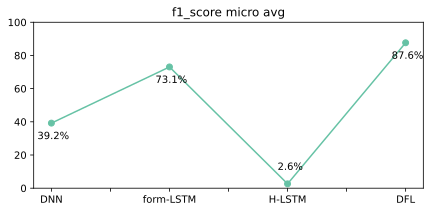

In [197]:
_df = sqldf(f"""
            SELECT model, (SUM(score) / COUNT(*)) * 100 as score 
            FROM f1_micro_type2
            WHERE 'DFL-weight' != model
            GROUP BY model
            """)
plot = _df.plot(x="model", y=f"score", kind='line', figsize=(7,3), title=f"f1_score micro avg", xlabel="", colormap="Set2", legend=False, marker="o")
plot.set_ylim(0,100)
for idx, (x,y) in enumerate(zip(_df["model"], _df["score"])):
    label = f"{y:.1f}%"
    plot.annotate(label, # this is the text
                (idx, y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(-14,-16) if y > 20 else (-10, 14), # distance from text to points (x,y)
                ha='left')

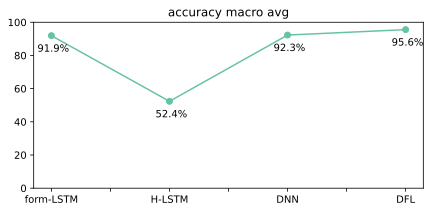

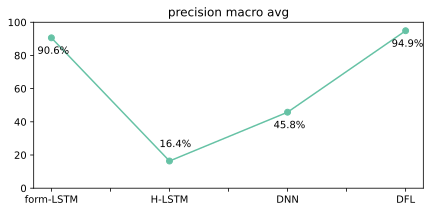

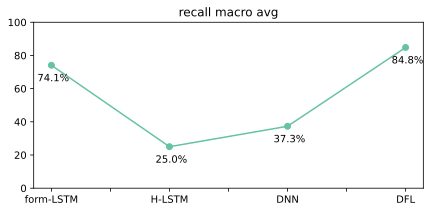

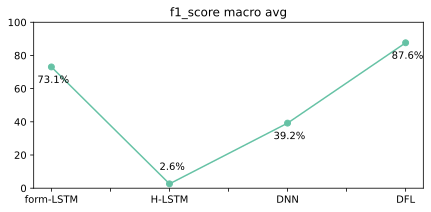

In [200]:

model_name = {
    "DNN": "DNN",
    'file_data_LSTM':"form-LSTM",
    'payload_LSTM':"H-LSTM",
    'non_weighted_Ensemble':"DFL",
    'weighted_Ensemble':"DFL-weight",
    "form-LSTM":"form-LSTM",
    "H-LSTM":"H-LSTM",
    "DFL":"DFL",
    "DFL-weight":"DFL-weight",
}
analysis["model"] = analysis['model'].apply(lambda x: model_name[x])

SUBPLOT = False
if SUBPLOT:
  fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
  fig.subplots_adjust(hspace=1)
  plots = [
    sqldf(f"""
            SELECT model, SUM(M) / COUNT(*) as score 
            FROM analysis
            WHERE score_type = '{score_type}'
            GROUP BY model
            """)\
              .plot(x="model", y=["score"], kind='line', figsize=(7,3), title=[f"{score_type} macro avg"], subplots=True,  ax=axes[iy], xlabel="", colormap="Set2")
      for iy, score_type in enumerate(sqldf("SELECT DISTINCT score_type FROM analysis")["score_type"])
  ]
else:
  for iy, score_type in enumerate(sqldf("SELECT DISTINCT score_type FROM analysis")["score_type"]):
    _df = sqldf(f"""
            SELECT model, (SUM(M) / COUNT(*)) * 100 as score 
            FROM analysis
            WHERE score_type = '{score_type}'
            GROUP BY model
            """)
    # _df["model"] = _df["model"].astype("str").apply(lambda x: model_name[x])
    plot = _df.plot(x="model", y=f"score", kind='line', figsize=(7,3), title=f"{score_type} macro avg", xlabel="", colormap="Set2", legend=False, marker="o")
    plot.set_ylim(0,100)
    for idx, (x,y) in enumerate(zip(_df["model"], _df["score"])):
      label = f"{y:.1f}%"
      plot.annotate(label, # this is the text
                 (idx, y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(-14,-16) if y > 20 else (-10, 14), # distance from text to points (x,y)
                 ha='left')
      

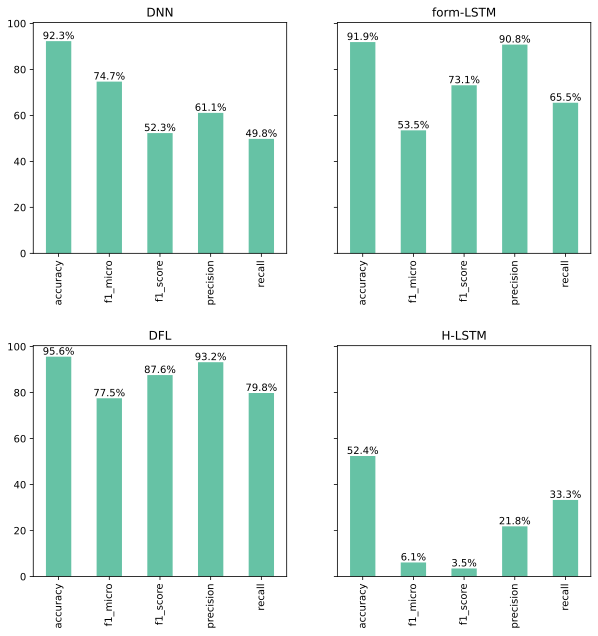

In [242]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True)
fig.subplots_adjust(hspace=.4)

for iy, model in enumerate(sqldf("SELECT DISTINCT model FROM analysis")["model"]):
  _data = sqldf(f"""
          SELECT score_type, ROUND(SUM(M) / COUNT(*) * 1000) / 10 as score 
          FROM (
            SELECT score_type, M, model
            FROM analysis
            UNION (
              SELECT 'f1_micro', score, model
              FROM f1_micro_type2
            )
          ) as df
          WHERE model = '{model}'
          GROUP BY score_type
          ORDER BY score_type
          """)
  plot = _data.plot(x="score_type", y=["score"], kind='bar', subplots=True, figsize=(7,7), title=[f"{model}"], ax=axes[iy % 2, iy // 2 - 1], xlabel="", legend=False, colormap="Set2")
  for bar in axes[iy % 2, iy // 2 - 1].containers:
    axes[iy % 2, iy // 2 - 1].bar_label(bar, fmt='%g%%')

In [26]:
datas = [
    ([
        sqldf(f"""SELECT model, SUM(M) / COUNT(*) as score 
            FROM analysis 
            WHERE model = '{model}'
                AND score_type = '{score_type}'
            GROUP BY score_type, model""")
            for model in sqldf("SELECT DISTINCT model FROM analysis")["model"]
    ], score_type)
    for score_type in sqldf("SELECT DISTINCT score_type FROM analysis")["score_type"]
]

In [27]:
data.head()

,model,attempt,score_type,attack_name,score
0,file_data_LSTM,0,accuracy,PW_Injection,0.841693
1,file_data_LSTM,0,accuracy,SQLi,1.000000
2,file_data_LSTM,0,accuracy,File_Inclusion,1.000000
3,file_data_LSTM,0,accuracy,XSS,0.841693
4,file_data_LSTM,0,precision,PW_Injection,0.827959


# Tukey HSD

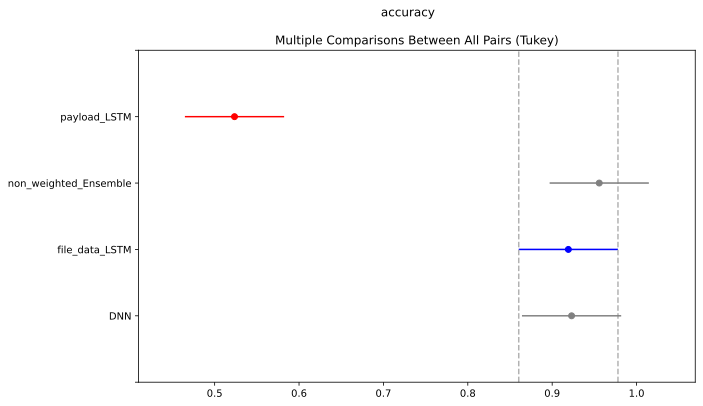

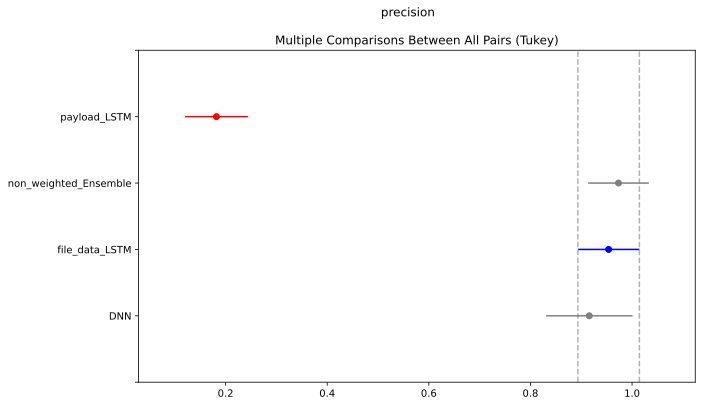

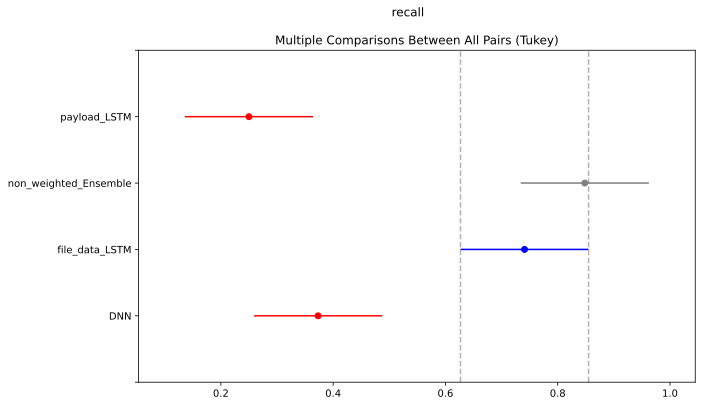

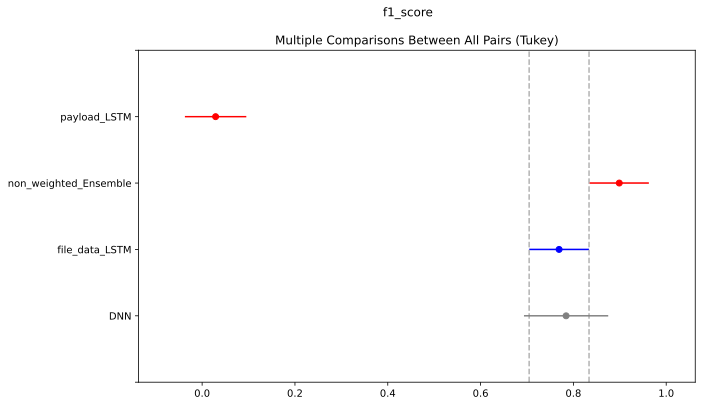

In [28]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from matplotlib import lines

for score_type in data["score_type"].unique():
    df = sqldf(f"""
            SELECT model, score
            FROM data
            WHERE score_type = '{score_type}'
                AND NOT score IS NULL
                -- AND model != 'payload_LSTM'
            """)
        # .plot(kind='box', figsize=(3,3))
    plot = pairwise_tukeyhsd(df['score'], df['model'], alpha=0.05).plot_simultaneous(df['model'][0])
    # left, right = plot.axes[0].get_xlim()
    # plot.axes[0].set_xlim(min(-.01, left), max(.01, right))
    plot.suptitle(score_type)


# CA

In [29]:
import altair as alt
def getCA_plot(df, ca=None, title=None, annotProps={"fontSize": 10}, debug=False):
    if not ca:
        ca = prince.CA().fit(df)
    cc = ca.column_coordinates(df).reset_index()
    cc.columns = ['name', 'x', 'y']

    rc = ca.row_coordinates(df).reset_index()
    rc.columns = ['name', 'x', 'y']

    crc_df = pd.concat([cc, rc], ignore_index=True)
    if debug:
        print(crc_df)

    points = ca.plot(df)
    y_line = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule().encode(y='y')
    x_line = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule().encode(x='x')
    
    annot = alt.Chart(crc_df).mark_text(
        align='left',
        baseline='middle',
        dx = 7,
        **annotProps
    ).encode(
        x='x',
        y='y',
        text='name'
    )
    plot = points + annot + y_line + x_line
    if title:
        plot.title = title

    return plot

In [30]:
score_types = data["score_type"].unique()
cas = []
import os
for stype in score_types:
    input_X = sqldf(f"""
                    SELECT model, attack_name, SUM(score) / COUNT(*) * 100 as score
                    FROM data
                    WHERE score_type = '{stype}'
                        AND NOT score IS NULL
                    GROUP BY model, attack_name
                    """).pivot(index="model", columns="attack_name", values="score").fillna(0)

    # input_X.to_csv(os.path.join("statistics", f"{stype}_analysis.csv"))
    ca = prince.CA().fit(input_X)
    # plot = lambda : getCA_plot(input_X, ca, stype)
    cas.append([ca, input_X, stype])

In [31]:
# Accuracy
ca, input_X, stype = cas[0]
getCA_plot(input_X, ca, stype)

alt.LayerChart(...)

In [32]:
# precision
ca, input_X, stype = cas[1]
getCA_plot(input_X, ca, stype)

alt.LayerChart(...)

In [33]:
# recall
ca, input_X, stype = cas[2]
getCA_plot(input_X, ca, stype)

alt.LayerChart(...)

In [34]:
# f1_score
ca, input_X, stype = cas[3]
getCA_plot(input_X, ca, stype)

alt.LayerChart(...)